# paper wrapup - [Attention is All you need](https://arxiv.org/abs/1706.03762)

## Problem

### LSTM, GRU don't scale well

- 기존의 Sequence Modeling을 위해 사용되던 LSTM, GRU는 재귀적 특성(Sequence)으로 인해 병렬화에 제약을 지님
- 이러한 Sequence Length의 증가에 따른 Computation & Memory Complexity를 해결하기 위해 Convolution 기반의 방법 등이 시도되었으나 Long distance의 의존성을 제대로 다룰 수 없었음
  - 예를 임의의 두 위치의 거리에 따라서 
  - ConvS2S는 O(n)
  - ByteNet는 O(logN)
- 즉, long distance의 의존성을 적절하게 다룰 수 있으면서 동시에 sequence에 따른 복잡도를 최소화 할 수 있는 방법의 필요

### Transformers

- Transformer는 두 지점의 거리에 대해서 O(1)의 복잡도를 제공 (Generation의 경우 예외)
- Self-Attention은 Reading Comprehension, Semantic Representation, 등에 뛰어난 성능을 보였음
- Transfomer는 RNN이나 CNN 등을 사용하지 않고 순수하게 Self-Attention만을 사용한 최초의 사례

### Model Architecture

Encoder-Decoder Architecture

#### Encoder

- 6 identical layers
- each layer
  - multi-head self-attention (w/ residual connection)
  - position-wise feedforward (w/ residual connection)

```python

layer_1 = LayerNorm(MultiHeadSelfAttention(x) + x)
layer_2 = LayerNorm(PositionWiseFeedforward(x) + x)

```

#### Decoder

- 6 identical layers
- each layer
  - multi-head self-attention (w/ residual connection)
  - multi-head attention (w/ residual connection)
  - position-wise feedforward (w/residual connection)

```python

layer_1 = LayerNorm(MultiHeadAttention(x) + x)
layer_2 = LayerNorm(MultiHeadAttention(qk: encoder_output, v: x))
layer_3 = LayerNorm(PositionWiseFeedforward(x) + x)

```
  

## Scaled dot-product attention

- Attention의 주요 알고리즘으로 Scaled dot-product attention을 사용
- dot-product
  - attention을 구하는 연산으로 Mat Mul을 사용
- scaled
  - dimension of key and value. 즉, word embedding vector의 dimension dk
  - 1/sqrt(dk)로 attension을 scaling


```python
ScaledDotProduct(Q,K,V) = Softmax(Q@K.T / sqrt(dk))@V
```


In [2]:
import torch

class ScaledDotProductAttention(torch.nn.Module):

    def __init__(self, d_model, device=None, dtype: torch.dtype=torch.float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.dk = torch.sqrt(torch.scalar_tensor(d_model, device=device, dtype=dtype))
    
    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        # input should have (B,N,d_model)
        # q (b,1,d_model) , k (b,n,d_model)
        # qk = (b,1,n)
        scaled_qk = q@torch.transpose(k, 2, 1) / self.dk
        if mask is not None:
            scaled_qk = scaled_qk * mask
        attention_weights = torch.softmax(scaled_qk, dim=-1)
        return  attention_weights @  v
        



## Multi-Head attention

- d_model 즉, Query, Key ,Value의 word embedding vector를 다수의 sub vector로 나누어서 각 sub vector를 입력으로 하는 scaled dot-product attention 다수를 조합하여 하나의 Attention block을 구성함.

```python
MultiHeadAttention(Q,K,V,n_heads) = concat(*[ScaledDotProduct(linear(qi),linear(ki),linear(vi)) for qi,ki,vi in zip(Q.split(n_heads), K.split(n_heads), V.split(n_heads))])
```



In [3]:

import torch

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, d_model, n_head, device=None, dtype: torch.dtype=torch.float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.n_head = n_head
        self.depth = d_model // n_head

        self.q_linear = torch.nn.Linear(d_model, d_model, device=device, dtype=dtype)
        self.k_linear = torch.nn.Linear(d_model, d_model, device=device, dtype=dtype)
        self.v_linear = torch.nn.Linear(d_model, d_model, device=device, dtype=dtype)

        self.attns = torch.nn.ModuleList([ScaledDotProductAttention(d_model=self.depth, device=device, dtype=dtype) for _ in range(n_head)])
        self.output_linear = torch.nn.Linear(d_model, d_model, device=device, dtype=dtype)
                
        
    def forward(self, input: torch.Tensor, mask:torch.Tensor=None) -> torch.Tensor:
        if len(input.shape) == 2:
            input = input.unsqueeze(0)
        if len(input.shape) != 3:
            raise ValueError(f'unsupported tensor shape: {input.shape}, should be form of (B,N,d)')
        
        b,n,d = input.shape
        q = self.q_linear.forward(input).view((b, n, self.n_head, -1))
        k = self.k_linear.forward(input).view((b, n, self.n_head, -1))
        v = self.v_linear.forward(input).view((b, n, self.n_head, -1))
        attn_output = torch.concat([self.attns[i].forward(q[:,:,i,:].view((b,n,self.depth)), 
                                            k[:,:,i,:].view((b,n, self.depth)), 
                                            v[:,:,i,:].view((b,n, self.depth)), mask) for i in range(self.n_head)],dim=-1)
        return self.output_linear.forward(attn_output)
        

In [4]:
import torch


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
test = torch.rand((1, 1024, 512), device=device, dtype=torch.float16)

attention = MultiHeadAttention(512, 8, device=device, dtype=torch.float16)
attention = torch.compile(attention)




In [5]:
out = attention.forward(test)
out.shape

torch.Size([1, 1024, 512])

## Position-wise feedforward

- Linear - Relu - Linear


## Transformer Layer

- GPT논문의 Transformer layer는 Attention is all you need의 transformer는 Encoder 유사한 구조로 residual connection을 갖는 Multi-head attention과 position wise feedforward의 2개의 sublayer로 구성되어 있고 각 sublayer의 출력에 layer norm이 추가되는 형태
- 첫 GPT 논문에서는 이러한 transformer block 12개를 쌓아 model을 구성


In [31]:
import torch

class PositionWiseFeedforward(torch.nn.Module):

    def __init__(self, d_model:int, device, dtype: torch.dtype=torch.float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.pwff = torch.nn.Sequential(torch.nn.Linear(d_model, d_model * 4, device=device,dtype=dtype), 
                                            torch.nn.GELU(), 
                                            torch.nn.Linear(4* d_model, d_model, device=device, dtype=dtype))
        
    def forward(self, input: torch.Tensor)-> torch.Tensor:
        return self.pwff.forward(input)


class Transformer(torch.nn.Module):

    def __init__(self, n_head, d_model, device, dtype:torch.dtype=torch.float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.input_norm = torch.nn.LayerNorm(d_model, device=device, dtype=dtype)
        self.mha = MultiHeadAttention(d_model=d_model, n_head=n_head, device=device, dtype=dtype)
        self.mha_lnorm = torch.nn.LayerNorm(d_model, device=device,dtype=dtype)
        self.pw_ff = PositionWiseFeedforward(d_model=d_model, device=device, dtype=dtype)

    def forward(self, input:torch.Tensor, mask: torch.Tensor=None) -> torch.Tensor:
        # Pre-LayerNormalization from GPT-3, (note: Post-LayerNormalization is used for GPT-2 and original paper)
        norm_input = self.input_norm.forward(input)
        mha_output = input + self.mha.forward(norm_input, mask)
        norm_mha_output = self.mha_lnorm(mha_output)
        return mha_output + self.pw_ff.forward(norm_mha_output)


In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
transformer = Transformer(8, 512, device=device, dtype=torch.float16)
output = transformer.forward(test)
output.shape

torch.Size([1, 1024, 512])

## Embedding & Tokenization

- Text를 적절한 Numerical Representation으로 변형을 하기 위해서는 크게 2가지의 처리 단계를 필요로 하는데 이는 Tokenization과 Embedding이다.


### Tokenization
- Text를 최소 단위로 쪼개어 각 의미 단위에 고유한 ID를 부여하는 것.
- 최소 단위로 쪼개는 방식에 따라 Character Level Tokenization 부터 Subword Tokenization 등 다양한 방법이 있다. 
- 단, 신규 어휘의 확장에 유연하게 대응할 수 있는 장점을 지닌 Subword 방식을 많이 쓰고 있으며 BPE라는 방식이 유명하다.
  

In [33]:
import torch

vocab_size = 500
dense_rep = 50
batch = 8
seq = 64

input = torch.ones((batch, seq), dtype=torch.int) ## test input

embedding = torch.nn.Embedding(vocab_size, dense_rep) ## convert the token_id to dense vector

output = embedding.forward(input=input)

output.shape # would be (8,64,50)


torch.Size([8, 64, 50])

In [34]:
import lightning as L
from typing import Any
from lightning.pytorch.utilities.types import STEP_OUTPUT

class ToyGPT(L.LightningModule):

    def __init__(self, 
                 vocab_size:int, 
                 d_model:int, n_head:int, num_layers:int, pad_id:int=None,  device=None, dtype:torch.dtype=torch.float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.embedding = torch.nn.Embedding(vocab_size, d_model, padding_idx=pad_id, device=device, dtype=dtype)
        self.transformers = torch.nn.Sequential(*[Transformer(n_head=n_head, d_model=d_model, device=device, dtype=dtype) for _ in range(num_layers)])
        self.output_linear = torch.nn.Linear(d_model, vocab_size, device=device, dtype=dtype)
        self.softmax = torch.nn.Softmax(dim=-1)


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X should have shape of (B,N)
        if len(X.shape) == 1:
            X = X.unsqueeze(0)

        return self.softmax.forward(self.output_linear.forward(self.transformers.forward(self.embedding.forward(input=X))))
    

    def training_step(self, batch_input, batch_index, *args: Any, **kwargs: Any) -> STEP_OUTPUT:

        return super().training_step(*args, **kwargs)
    
    def test_step(self, batch_input, batch_index, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        return super().test_step(*args, **kwargs)

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

test_input = torch.tensor([0,1,2,3,4,0,0], dtype=torch.int, device=device)

gpt = ToyGPT(5000, 128, n_head=8, num_layers=4, pad_id=0, device=device, dtype=torch.float16)
output = gpt.forward(test_input)
output


tensor([[[1.9264e-04, 2.3949e-04, 2.5058e-04,  ..., 2.1100e-04,
          1.8418e-04, 1.1563e-04],
         [3.1519e-04, 4.2987e-04, 2.3699e-04,  ..., 7.5996e-05,
          4.4417e-04, 1.0359e-04],
         [1.1337e-04, 2.0766e-04, 1.7440e-04,  ..., 7.3850e-05,
          1.2201e-04, 5.0604e-05],
         ...,
         [1.1820e-04, 1.6356e-04, 3.3689e-04,  ..., 9.8586e-05,
          2.1982e-04, 8.1062e-05],
         [1.9264e-04, 2.3949e-04, 2.5058e-04,  ..., 2.1100e-04,
          1.8418e-04, 1.1563e-04],
         [1.9264e-04, 2.3949e-04, 2.5058e-04,  ..., 2.1100e-04,
          1.8418e-04, 1.1563e-04]]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SoftmaxBackward0>)

## `Masking` in Masked Attention


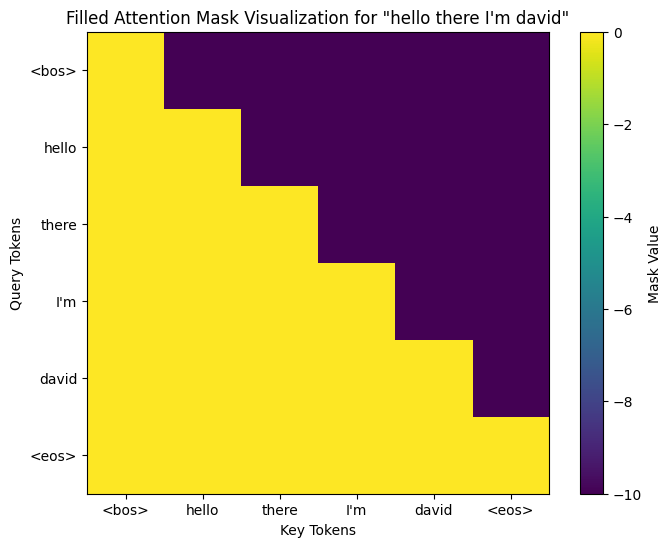

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Example sequence including special tokens
sequence = ["<bos>", "hello", "there", "I'm", "david", "<eos>"]
seq_length = len(sequence)

# Creating a mask with large negative numbers for visualization
filled_mask = np.triu(np.ones((seq_length, seq_length)), k=1) * -10

# Plotting the filled mask
plt.figure(figsize=(8, 6))
plt.imshow(filled_mask, cmap='viridis')
plt.colorbar(label='Mask Value')
plt.title('Filled Attention Mask Visualization for "hello there I\'m david"')
plt.xlabel('Key Tokens')
plt.ylabel('Query Tokens')
plt.xticks(ticks=range(seq_length), labels=sequence)
plt.yticks(ticks=range(seq_length), labels=sequence)
plt.show()



- Masking은 Scaled(Q@K.T)의 결과인 Attention Score에서 QnKm (where m > n)에 있는 값들을 -inf으로 변환한다.
- 이는 GPT와 같은 Autoregressive 모델의 주요한 목적, 즉, Sequence에서 한쪽의 정보를 기반으로 그 다음에 올 정보를 추정해야하는 모델에서 
- 추정의 정답 즉, Ground Truth에 대한 정보가 Training에 포함되는 것을 막기 위함이다.

### Tokenizer

- Pre-trained GPT2 tokenizer will be used
- Special Tokens
  - pad_token: `<pad>`
  - bos_token: `<s>`
  - eos_token: `</s>`
  


In [1]:
from transformers import PreTrainedTokenizer, GPT2Tokenizer

def get_tokenizer() -> PreTrainedTokenizer:
    
    tokenizer: PreTrainedTokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({"pad_token": "<pad>", "bos_token":"<s>", "eos_token":"</s>"}) # special 
    return tokenizer

get_tokenizer()

/home/fritzprix/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT2Tokenizer(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True)

## Dataset

- "wikimedia/wikisource", "20231201.en"
- HuggingFace의 Datasets와 Unstructured.io를 이용 Data의 download, pre-processing을 구현
- Lightening framework과 연동을 위해 LighteningDataModule을 구현


In [2]:
from typing import Any, List, Dict

import lightning as L
from datasets import Dataset, load_from_disk, load_dataset
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from transformers import PreTrainedTokenizer
from torch.utils import data
from unstructured.cleaners.core import (
    replace_unicode_quotes, clean, clean_ligatures
)
import re
from unstructured.cleaners.core import clean


### Pre-processing
- Text Cleansing
  - extra whitespace 제거
  - unicode quote 대체
  - ligatures 제거
- 이렇게 Cleansing된 Text를 완전한 Sentence 단위로 분절하여 Max Length에 맞도록 전처리하여 Local에 저장


In [3]:
class SentenceChunker:
    """
    A class responsible for chunking text into sentences and tokenizing them
    according to a specified maximum length.

    Attributes:
        tokenizer (PreTrainedTokenizer): A tokenizer from the transformers library
                                         used for tokenizing sentences.
        max_length (int): The maximum token length for a single chunk.
    """

    def _split_into_sentences(self, text):
        """
        Splits the input text into sentences.

        The text is first cleaned to standardize it (removing extra whitespaces, 
        replacing unicode quotes, and removing ligatures). Then, it is split into 
        sentences using a regular expression that looks for sentence end markers 
        (., !, ?) followed by a whitespace.

        Args:
            text (str): The text to be split into sentences.

        Returns:
            List[str]: A list of sentences extracted from the input text.
        """
        # Clean the text and split it into sentences
        clean_text = replace_unicode_quotes(clean_ligatures(clean(text, extra_whitespace=True)))
        sentences = re.split(r'(?<=[.!?])\s+', clean_text)
        return [sentence for sentence in sentences]

    def __init__(self, tokenizer: PreTrainedTokenizer, max_length:int) -> None:
        """
        Initializes the SentenceChunker with a tokenizer and a maximum length.

        Args:
            tokenizer (PreTrainedTokenizer): The tokenizer to be used for tokenization.
            max_length (int): The maximum token length for a single chunk.
        """
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, batch, *args: Any, **kwds: Any) -> Any:
        """
        Processes a batch of text sequences by first splitting them into sentences,
        then encoding each sentence. The sentences are then chunked according to the 
        maximum length, ensuring no chunk exceeds this limit.

        Args:
            batch: A batch of text sequences.

        Returns:
            Dict[str, List]: A dictionary with two keys, 'success' and 'failure'.
                             'success' contains chunks that are within the max_length,
                             'failure' contains chunks that exceed the max_length.
        """
        # Handle single string inputs by wrapping them in a list
        if isinstance(batch, str):
            batch = [batch]

        # Split each sequence in the batch into sentences and encode them
        batch_of_chunks = [self._split_into_sentences(seq) for seq in batch]
        batch_of_encodings = [self.tokenizer.batch_encode_plus(chunks, return_length=True) for chunks in batch_of_chunks]

        result = {"success": [], "failure": []}
        success_batch_bucket = []
        failure_batch_bucket = []

        # Iterate over each sequence's encodings and chunk them
        for bi, encodings in enumerate(batch_of_encodings):
            bucket = []
            tokens_total = 0

            # Process each sentence in the sequence
            for n, token_count in enumerate(encodings["length"]):
                # Handle sentences that exceed the max length
                if token_count > self.max_length:
                    failure_batch_bucket.append({"text":batch_of_chunks[bi][n], "length": token_count})
                    continue

                # Check if adding the sentence would exceed the max length
                if token_count + tokens_total > self.max_length:
                    # Current bucket is full, save and reset it
                    success_batch_bucket.append({"text":' '.join(bucket), "length": tokens_total})
                    bucket.clear()
                    tokens_total = 0
                
                # Add the sentence to the current bucket
                bucket.append(batch_of_chunks[bi][n])
                tokens_total += token_count

            # Append the processed batches to the result
            result["success"].append([*success_batch_bucket])
            result['failure'].append([*failure_batch_bucket])
            success_batch_bucket.clear()
            failure_batch_bucket.clear()

        return result


### Loading
- shuffling
- batch tokenization



In [4]:

class SuccessCaseGenerator:
    def __init__(self, datasets: List[Dataset], transform=None) -> None:
        self.datasets = datasets
        self.transform = transform

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        for ds in self.datasets:
            for b in ds["success"]:
                for seq in b:
                    if self.transform:
                        seq = self.transform(seq)
                    yield seq


class WikiSourceDataModule(L.LightningDataModule):

    def __init__(self, tokenizer: PreTrainedTokenizer, max_length:int, batch_size:int, languages:List[str]=['en'], train_size:float=0.9, num_proc=15) -> None:
        super().__init__()
        self.languages = languages
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.train_size = train_size
        self.batch_size = batch_size
        self.num_proc = num_proc


    def prepare_data(self) -> None:

        def transform(v:Dict[str, Any]) -> str:
            return {"length": v["length"], "text": f"<s>{v['text']}</s>"}
        
        sentence_chunker = SentenceChunker(self.tokenizer, self.max_length - 2)
        datasets = [load_dataset('wikimedia/wikisource', f"20231201.{lang}")["train"].map(lambda b: sentence_chunker(b["text"]), batched=True, num_proc=self.num_proc).flatten() for lang in self.languages]
        success_ds = Dataset.from_generator(SuccessCaseGenerator(datasets, transform=transform))
        success_ds = success_ds.train_test_split(test_size=(1 - self.train_size), train_size=self.train_size)
        success_ds.save_to_disk('local_dscache')

    def setup(self, stage: str) -> None:
        self.dataset = load_from_disk('local_dscache')
        self.train_dataset = self.dataset['train'].train_test_split(test_size=(1 - self.train_size), train_size=self.train_size)

        return super().setup(stage)

    def _tokenize(self, data):
            inputs = data['text']
            return self.tokenizer.batch_encode_plus(inputs, return_tensors="pt", padding=True, return_length=True, max_length=self.max_length)
    
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        train_dataset = self.train_dataset["train"].shuffle().map(self._tokenize, batched=True, batch_size=self.batch_size, num_proc=self.num_proc)
        return data.DataLoader(train_dataset.with_format(type="torch"))
    
    def val_dataloader(self) -> EVAL_DATALOADERS:
        val_dataset = self.train_dataset["test"].shuffle().map(self._tokenize, batched=True, batch_size=self.batch_size, num_proc=self.num_proc)
        return data.DataLoader(val_dataset.with_format(type="torch"))
    
    def test_dataloader(self) -> EVAL_DATALOADERS:
        test_dataset = self.dataset["test"].shuffle().map(self._tokenize, batched=True, batch_size=self.batch_size, num_proc=self.num_proc)
        return data.DataLoader(test_dataset.with_format(type="torch"))
    
    


In [6]:
from data import WikiSourceDataModule
tokenizer = get_tokenizer()
data = WikiSourceDataModule(tokenizer, 510, batch_size=4, languages=['en'])
data.prepare_data()
data.setup("fit")
train_data = data.train_dataloader()
val_data = data.val_dataloader()
test_data = data.test_dataloader()

Map (num_proc=15):   0%|          | 0/843041 [00:00<?, ? examples/s]/home/fritzprix/miniconda3/envs/torch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Map (num_proc=15):   0%|          | 160/843041 [00:00<53:08, 264.33 examples/s] /home/fritzprix/miniconda3/envs/torch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Map (num_proc=15):   0%|          | 572/843041 [00:01<17:58, 780.98 examples/s]/home/fritzprix/miniconda3/envs/torch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to ma

In [8]:
from tqdm import tqdm


def get_tokens_count(loader):
    overall_token_count = 0
    for data in tqdm(loader):
        token_lengths = data['length']
        overall_token_count += token_lengths.sum()

    return overall_token_count

print(f"training : {get_tokens_count(train_data) / 1e9} billion tokens")
print(f"validation : {get_tokens_count(val_data) / 1e9} billion tokens")
print(f"test : {get_tokens_count(test_data) / 1e9} billion tokens")



100%|██████████| 843041/843041 [01:45<00:00, 7986.92it/s]


training : 0.40628108382225037 billion tokens


100%|██████████| 93672/93672 [00:11<00:00, 7899.49it/s]


validation : 0.04514230415225029 billion tokens


100%|██████████| 104080/104080 [00:12<00:00, 8037.91it/s]

test : 0.05013979598879814 billion tokens
